In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from scipy.sparse import lil_matrix, coo_matrix, diags
from scipy.sparse.linalg import svds, eigsh
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
%matplotlib inline
sns.set(style="whitegrid")

In [26]:
from sklearn.datasets import load_digits

# Load dataset
data = load_digits()
X = data.data  # Feature matrix
y = data.target  # Ground truth labels for evaluation

In [27]:
print(data.data.shape)

(1797, 64)


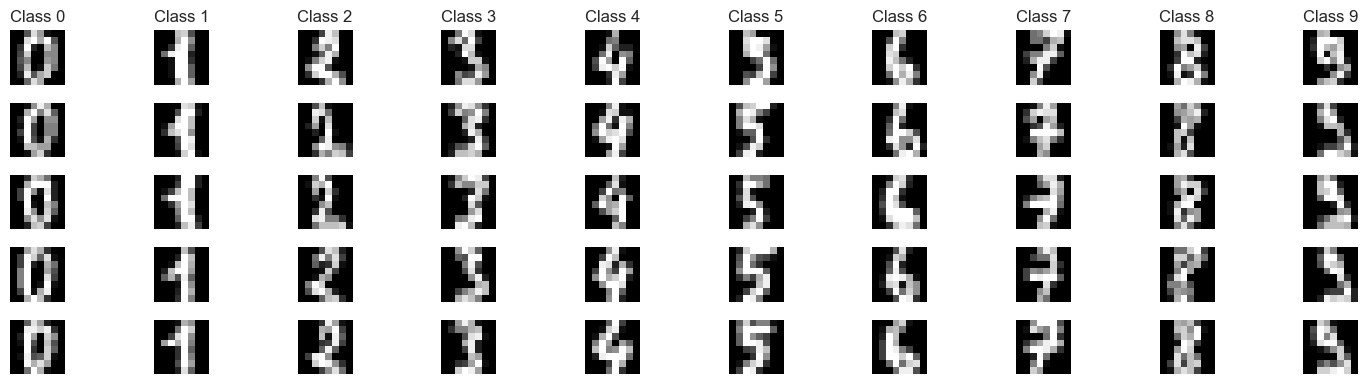

In [28]:
fig, axes = plt.subplots(5, 10, figsize=(15, 4))
classes = np.unique(y)
example_count = 5

for i, cls in enumerate(classes):
    class_indices = np.where(y == cls)[0][:example_count]
    for j, idx in enumerate(class_indices):
        ax = axes[j, i]
        ax.imshow(data.images[idx], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f'Class {cls}')

plt.tight_layout()
plt.show()

## Normalization

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

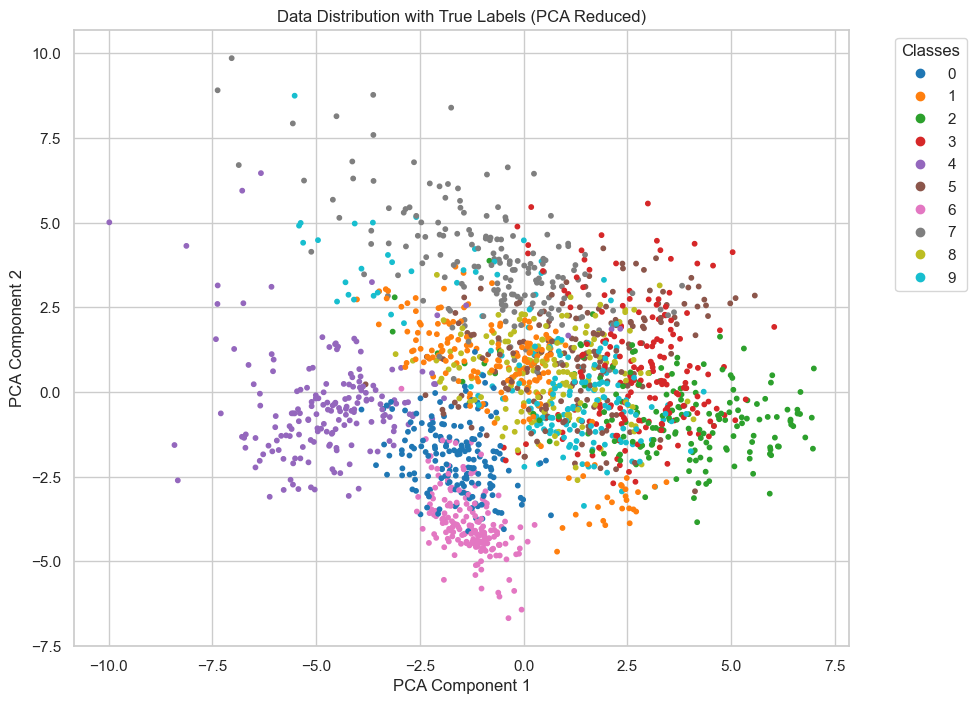

In [30]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot the data colored by true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Data Distribution with True Labels (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [31]:
def BKHK(data, num_anchors):
    """
    Balanced K-means-based Hierarchical K-means (BKHK) implementation.
    Returns:
    - anchors: array of anchor points
    - anchor_assignments: array of anchor indices for each sample
    """
    n_samples = data.shape[0]
    anchor_assignments = np.zeros(n_samples, dtype=int)
    anchors = []
    datasets = [(data, np.arange(n_samples), 0)]  # (data, indices, depth)
    cluster_id = 0
    while len(anchors) < num_anchors and datasets:
        new_datasets = []
        for subset_data, indices, depth in datasets:
            if len(subset_data) <= 1:
                anchors.append(subset_data[0])
                continue
            kmeans = KMeans(n_clusters=2, random_state=42)
            labels = kmeans.fit_predict(subset_data)
            # Update anchor assignments
            anchor_label = cluster_id
            anchor_assignments[indices[labels == 0]] = cluster_id
            anchors.append(kmeans.cluster_centers_[0])
            cluster_id += 1
            anchor_assignments[indices[labels == 1]] = cluster_id
            anchors.append(kmeans.cluster_centers_[1])
            cluster_id += 1
            # Add new subsets
            idx0 = indices[labels == 0]
            idx1 = indices[labels == 1]
            data0 = subset_data[labels == 0]
            data1 = subset_data[labels == 1]
            new_datasets.append((data0, idx0, depth + 1))
            new_datasets.append((data1, idx1, depth + 1))
            if len(anchors) >= num_anchors:
                break
        datasets = new_datasets
    # Return required number of anchors and assignments
    anchors = np.array(anchors[:num_anchors])
    return anchors, anchor_assignments

# Set the desired number of anchors
num_anchors = 45
anchors, anchor_assignments = BKHK(X_scaled, num_anchors)

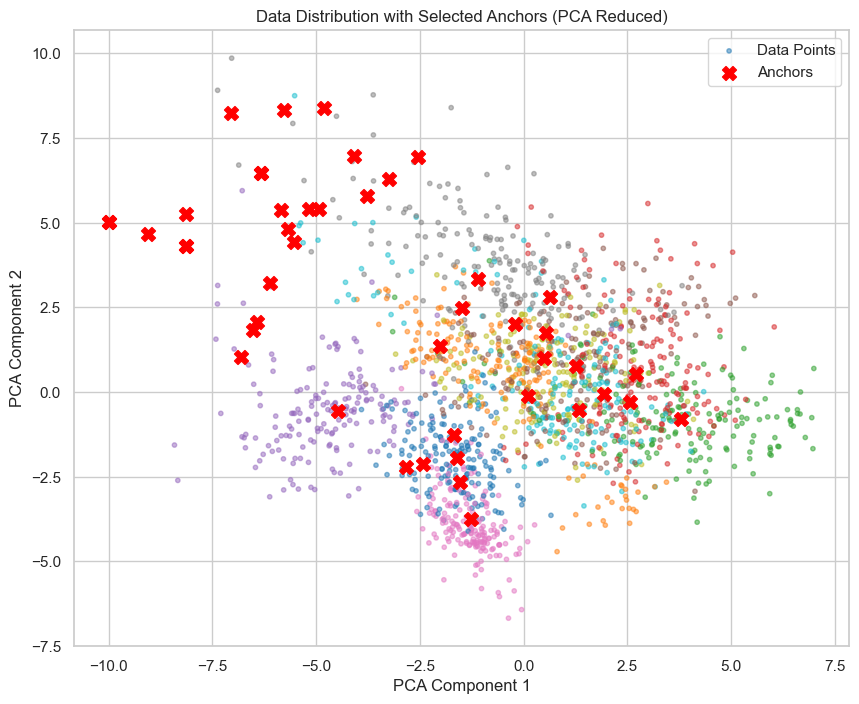

In [32]:
# Plot data points and selected anchors
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10, alpha=0.5, label='Data Points')
anchors_pca = pca.transform(anchors)  # Reduce anchors to 2D
plt.scatter(anchors_pca[:, 0], anchors_pca[:, 1], c='red', marker='X', s=100, label='Anchors')
plt.legend()
plt.title("Data Distribution with Selected Anchors (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [33]:
def compute_anchor_neighbors(anchors, K_prime):
    """
    Compute the K' nearest anchors for each anchor.
    """
    nbrs = NearestNeighbors(n_neighbors=K_prime + 1, algorithm='auto').fit(anchors)
    distances, indices = nbrs.kneighbors(anchors)
    # Exclude self (the first neighbor is the anchor itself)
    anchor_neighbors = indices[:, 1:]
    return anchor_neighbors

# Set K' (should be greater than K)
K_prime = 13
anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)

In [34]:
def compute_sample_anchor_similarities(data, anchors, anchor_assignments, anchor_neighbors, K):
    """
    Compute the similarities between each sample and its K nearest anchors.
    Returns:
    - W: sparse matrix of shape (n_samples, n_anchors) with similarities
    """
    n_samples = data.shape[0]
    n_anchors = anchors.shape[0]
    W = lil_matrix((n_samples, n_anchors))
    for i in range(n_samples):
        # Find the anchor assignment for this sample
        anchor_idx = anchor_assignments[i]
        # Candidate anchors are the K' nearest anchors to this anchor
        candidate_anchor_indices = anchor_neighbors[anchor_idx]
        # Compute distances to candidate anchors
        candidate_anchors = anchors[candidate_anchor_indices]
        distances = np.linalg.norm(data[i] - candidate_anchors, axis=1)
        # Get K nearest anchors
        K_nearest_indices = np.argsort(distances)[:K]
        K_anchor_indices = candidate_anchor_indices[K_nearest_indices]
        K_distances = distances[K_nearest_indices]
        # Compute similarities (using normalized inverse distances)
        similarities = 1 / (K_distances + 1e-10)
        similarities /= similarities.sum()
        # Assign to W
        W[i, K_anchor_indices] = similarities
    return W.tocsr()

# Set K (number of nearest anchors to consider)
K = 2
W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)

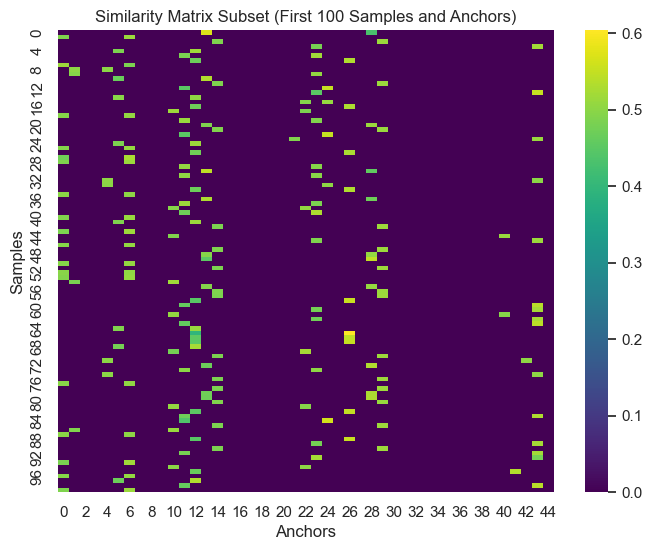

In [35]:
# Convert W to dense for visualization (use a subset for large matrices)
subset = 100  # Number of samples and anchors to visualize
W_dense = W[:subset, :subset].toarray()

plt.figure(figsize=(8, 6))
sns.heatmap(W_dense, cmap='viridis')
plt.title("Similarity Matrix Subset (First 100 Samples and Anchors)")
plt.xlabel("Anchors")
plt.ylabel("Samples")
plt.show()

In [36]:
def compute_svd(W, n_components):
    """
    Compute the top n_components left singular vectors of W.
    Returns:
    - U: array of shape (n_samples, n_components)
    """
    U, Sigma, VT = svds(W, k=n_components)
    # Sort the singular values and vectors in descending order
    idx = np.argsort(-Sigma)
    U = U[:, idx]
    return U

# Set the number of components (should be greater than the max number of clusters)
n_components = 20
U = compute_svd(W, n_components)

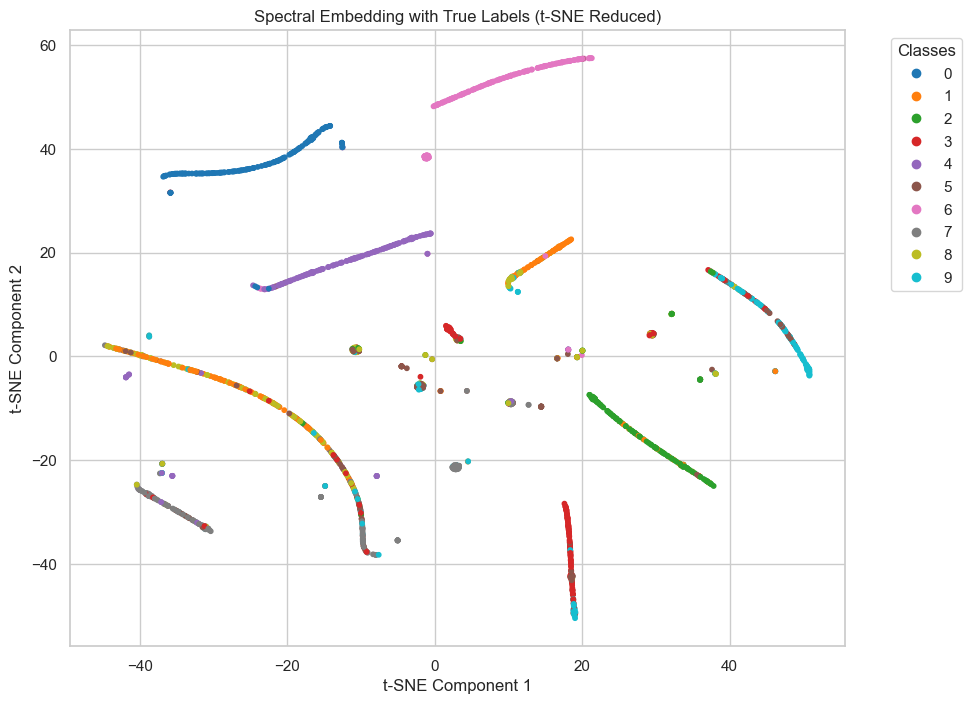

In [37]:
# Reduce spectral embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
U_tsne = tsne.fit_transform(U)

# Plot the spectral embeddings colored by true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Spectral Embedding with True Labels (t-SNE Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [38]:
def generate_base_clusterings(U, num_clusters_list):
    """
    Generate base clusterings by running K-means with different numbers of clusters.
    Returns:
    - base_clusterings: list of arrays of cluster labels
    """
    base_clusterings = []
    for k in num_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=None)
        labels = kmeans.fit_predict(U)
        base_clusterings.append(labels)
    return base_clusterings

# Define a list of different cluster numbers
num_clusters_list = [8, 9, 10, 11, 12]
base_clusterings = generate_base_clusterings(U, num_clusters_list)

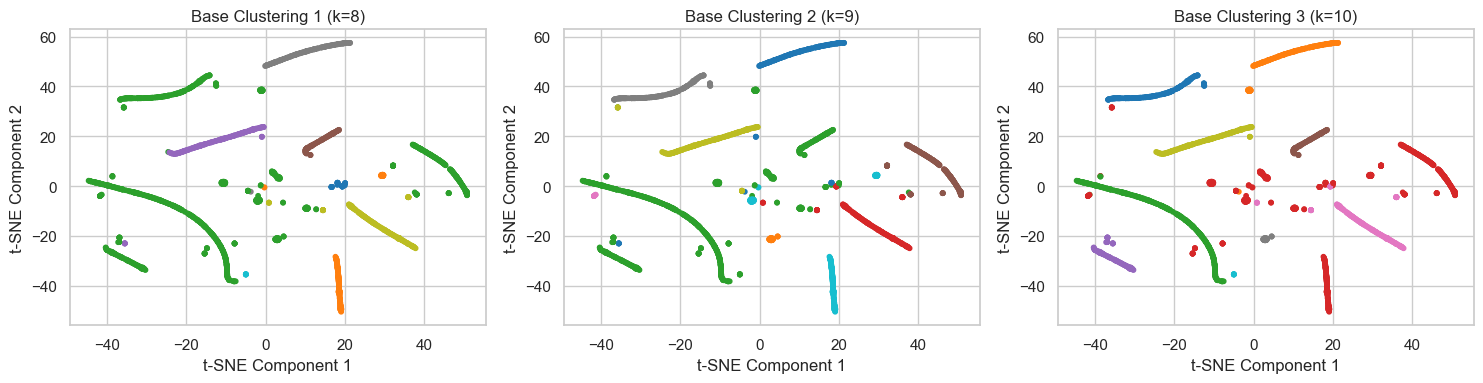

In [39]:
# Visualize first 3 base clusterings
num_visualize = 3
plt.figure(figsize=(15, 4))
for i in range(num_visualize):
    plt.subplot(1, num_visualize, i+1)
    labels = base_clusterings[i]
    plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(f"Base Clustering {i+1} (k={num_clusters_list[i]})")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

In [40]:
def build_bipartite_graph(base_clusterings):
    """
    Build the bipartite graph from base clusterings.
    Returns:
    - H: incidence matrix (n_samples, n_clusters_total)
    """
    n_samples = base_clusterings[0].shape[0]
    cluster_id = 0
    data = []
    rows = []
    cols = []
    for labels in base_clusterings:
        unique_labels = np.unique(labels)
        label_mapping = {label: idx + cluster_id for idx, label in enumerate(unique_labels)}
        mapped_labels = np.vectorize(label_mapping.get)(labels)
        for i in range(n_samples):
            rows.append(i)
            cols.append(mapped_labels[i])
            data.append(1)
        cluster_id += len(unique_labels)
    n_clusters_total = cluster_id
    H = coo_matrix((data, (rows, cols)), shape=(n_samples, n_clusters_total))
    return H.tocsr()

H = build_bipartite_graph(base_clusterings)

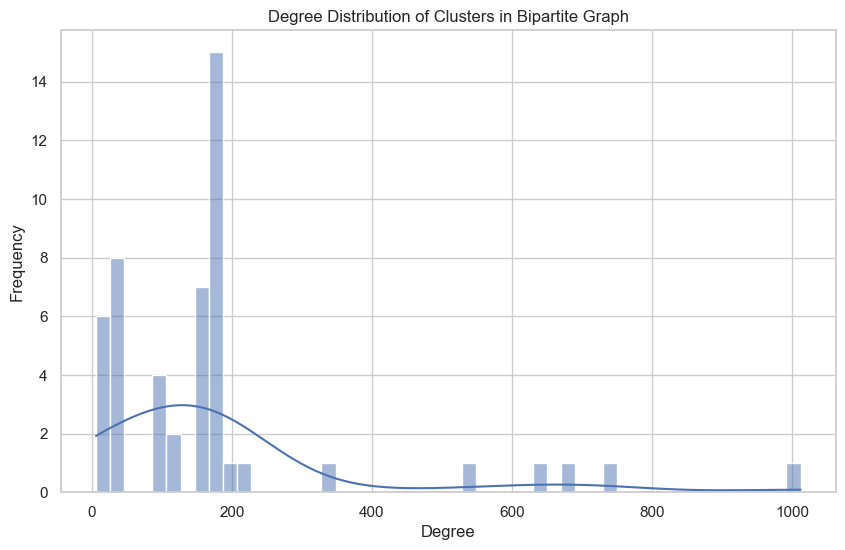

In [41]:
# Compute degree of each cluster
cluster_degrees = np.array(H.sum(axis=0)).flatten()

plt.figure(figsize=(10, 6))
sns.histplot(cluster_degrees, bins=50, kde=True)
plt.title("Degree Distribution of Clusters in Bipartite Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [42]:
def consensus_clustering(H, n_clusters):
    """
    Perform consensus clustering using spectral clustering on the bipartite graph.
    Returns:
    - final_labels: array of cluster labels
    """

    # Compute the degree vector of clusters
    D_c = np.array(H.sum(axis=0)).flatten()
    # Create a sparse diagonal matrix for D_c_inv
    D_c_inv = diags(1.0 / D_c)

    # Compute the Laplacian L_s = H * D_c^{-1} * H^T
    L_s = H.dot(D_c_inv).dot(H.T)

    # Ensure L_s is a symmetric matrix (if necessary)
    # L_s = (L_s + L_s.T) / 2

    # Compute the eigenvectors
    n_components = n_clusters
    vals, vecs = eigsh(L_s, k=n_components, which='LA')

    # Use the eigenvectors for clustering
    kmeans = KMeans(n_clusters=n_clusters)
    final_labels = kmeans.fit_predict(vecs)
    return final_labels

# Set the desired number of clusters in the final result
final_n_clusters = 10
final_labels = consensus_clustering(H, final_n_clusters)

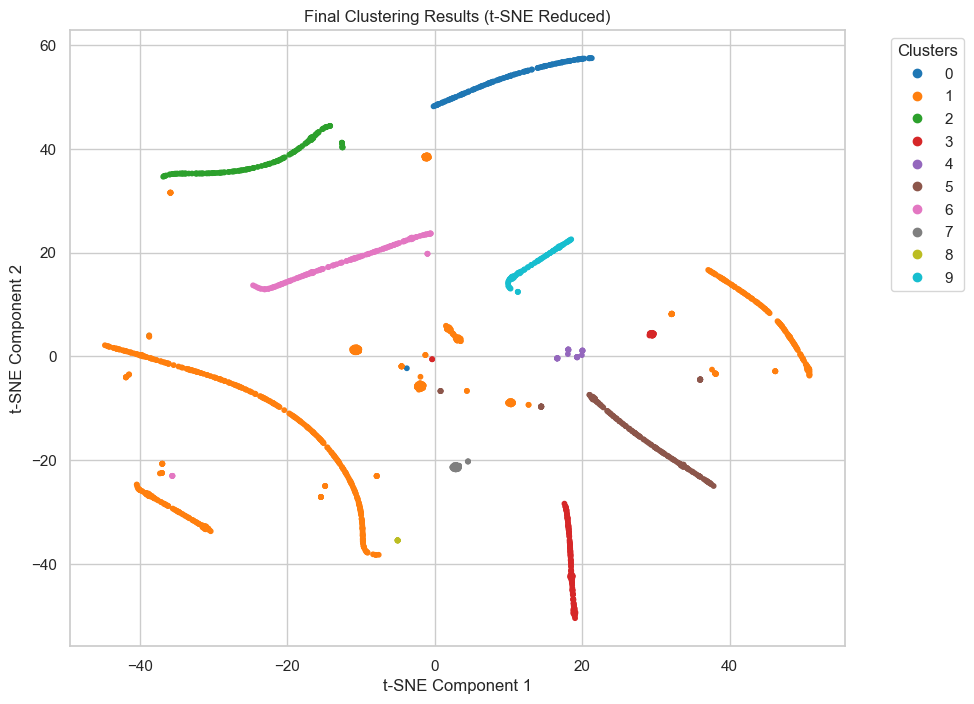

In [43]:
# Reduce the final clustering labels for visualization using PCA
# Already have U_tsne from earlier

# Plot the final clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=final_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Final Clustering Results (t-SNE Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [44]:
# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y, final_labels)
# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y, final_labels)
# Clustering Accuracy (Optional, requires Hungarian Algorithm)
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy using the Hungarian algorithm.
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / y_pred.size

acc = clustering_accuracy(y, final_labels)

print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Clustering Accuracy (ACC): {acc:.4f}")

Normalized Mutual Information (NMI): 0.5324
Adjusted Rand Index (ARI): 0.2592
Clustering Accuracy (ACC): 0.5287


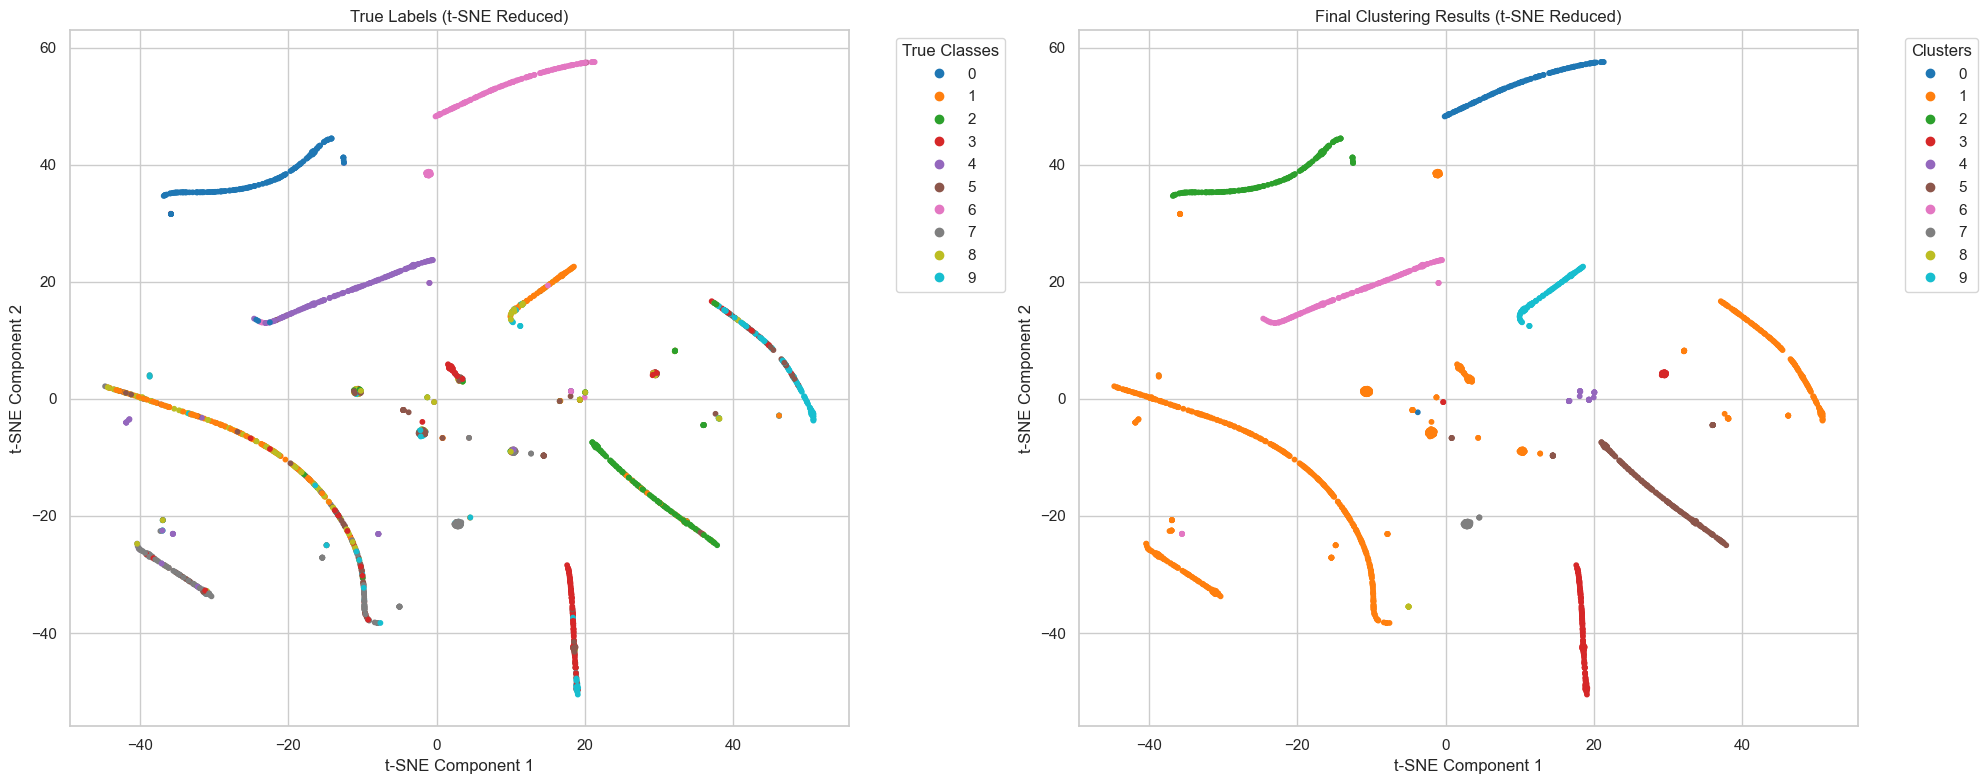

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# True Labels
scatter = axes[0].scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
axes[0].legend(*scatter.legend_elements(), title="True Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("True Labels (t-SNE Reduced)")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")

# Final Clusters
scatter = axes[1].scatter(U_tsne[:, 0], U_tsne[:, 1], c=final_labels, cmap='tab10', s=10)
axes[1].legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Final Clustering Results (t-SNE Reduced)")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

## Optimizations
### Random search

In [23]:
# from itertools import product

# param_grid = {
#     'num_anchors': np.random.randint(25, 200, 10),
#     'K_prime': np.random.randint(2, 20, 5),
#     'K': np.random.randint(1, 15, 5),
#     'n_components': np.random.randint(10, 40, 5),
# }

# best_nmi = -1
# best_params = {}

# for num_anchors, K_prime, K, n_components in product(*param_grid.values()):
#     # Run FSEC with these parameters
#     anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
#     anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
#     W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
#     U = compute_svd(W, n_components)
#     base_clusterings = generate_base_clusterings(U, [8, 9, 10, 11, 12])
#     H = build_bipartite_graph(base_clusterings)
#     final_labels = consensus_clustering(H, n_clusters=10)
    
#     # Evaluate
#     nmi = normalized_mutual_info_score(y, final_labels)
    
#     if nmi > best_nmi:
#         best_nmi = nmi
#         best_params = {
#             'num_anchors': num_anchors,
#             'K_prime': K_prime,
#             'K': K,
#             'n_components': n_components
#         }

# print(f"Best NMI: {best_nmi}")
# print(f"Best Parameters: {best_params}")

### Bayesian Optimization

In [24]:
import optuna

def objective(trial):
    num_anchors = trial.suggest_int('num_anchors', 25, 100)
    K_prime = trial.suggest_int('K_prime', 2, 15)
    K = trial.suggest_int('K', 1, 15)
    n_components = trial.suggest_int('n_components', 20, 40)
    
    if num_anchors < n_components:
        return 0.0
    
    if K_prime <= K:
        return 0.0
    
    anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
    anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
    W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
    U = compute_svd(W, n_components)
    base_clusterings = generate_base_clusterings(U, [8, 9, 10, 11, 12])
    H = build_bipartite_graph(base_clusterings)
    final_labels = consensus_clustering(H, n_clusters=10)
    
    nmi = normalized_mutual_info_score(y, final_labels)
    return nmi

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

print(f"Best NMI: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-11-19 01:11:36,245] A new study created in memory with name: no-name-53679905-8d3d-4a57-9422-f97e23fe7cc4
[I 2024-11-19 01:11:36,246] Trial 0 finished with value: 0.0 and parameters: {'num_anchors': 96, 'K_prime': 2, 'K': 5, 'n_components': 35}. Best is trial 0 with value: 0.0.
[I 2024-11-19 01:11:36,247] Trial 1 finished with value: 0.0 and parameters: {'num_anchors': 29, 'K_prime': 13, 'K': 15, 'n_components': 28}. Best is trial 0 with value: 0.0.
[I 2024-11-19 01:11:36,248] Trial 2 finished with value: 0.0 and parameters: {'num_anchors': 64, 'K_prime': 5, 'K': 14, 'n_components': 36}. Best is trial 0 with value: 0.0.
[I 2024-11-19 01:11:36,541] Trial 3 finished with value: 0.3146068341013568 and parameters: {'num_anchors': 83, 'K_prime': 13, 'K': 11, 'n_components': 39}. Best is trial 3 with value: 0.3146068341013568.
[I 2024-11-19 01:11:36,797] Trial 4 finished with value: 0.4083834054222729 and parameters: {'num_anchors': 56, 'K_prime': 6, 'K': 5, 'n_components': 40}. Best

Best NMI: 0.5787498963520562
Best Parameters: {'num_anchors': 45, 'K_prime': 13, 'K': 2, 'n_components': 20}
